In [2]:
Z_DIM = 3

### 1. Load dataset

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from PIL import Image, ImageColor
from pathlib import Path

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch import tensor
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset

import torch.distributions.constraints as constraints
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='Set2')
import time


import pandas as pd
from tqdm import tqdm

from IPython.display import clear_output

!pip install -q pyro-ppl
import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, SGD
from pyro.infer import TraceEnum_ELBO, config_enumerate, infer_discrete

pyro.set_rng_seed(0)
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)


In [4]:
import os

In [5]:
class Synthetic(Dataset):
    def __init__(self, root, dataset="train"):
        root = root + "/" + dataset

        imgs = os.listdir(root)
        imgs = [i for i in imgs if i != '.DS_Store']

        self.dataset = dataset

        self.imgs = [os.path.join(root, k) for k in imgs]
        self.imglabel = [list(map(int, k[:-4].split("_")[1:])) for k in imgs]
        self.transforms = transforms.Compose([transforms.ToTensor(),
                                              transforms.Normalize((0.5, 0.5, 0.5, 0), (0.5, 0.5, 0.5, 1))])
    def __getitem__(self, idx):
        img_path = self.imgs[idx]

        label = torch.from_numpy(np.asarray(self.imglabel[idx]))
        pil_img = Image.open(img_path)
        label = torch.from_numpy(np.asarray(label))
        if self.transforms:
            data = self.transforms(pil_img)[:3]
        else:
            pil_img = np.asarray(pil_img)[:, :, :3].reshape(96, 96, 3)
            data = torch.from_numpy(pil_img)
        ret = {
            'img': data,
            'label': label,
        }
        return ret

    def __len__(self):
        return len(self.imgs)

In [6]:
dataset_dir = '../../data/pendulum/pendulum'
train_dataset = Synthetic(dataset_dir, "train")
test_dataset = Synthetic(dataset_dir, "test")
cf_dataset = Synthetic(dataset_dir, "cf")
train_dataset[0]['img'].shape

torch.Size([3, 96, 96])

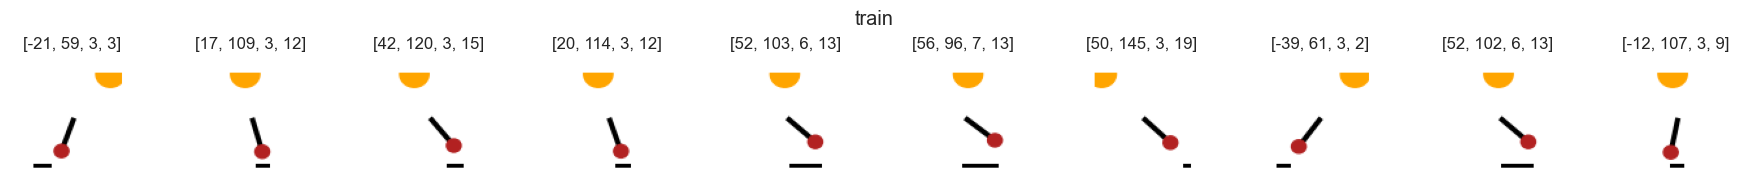

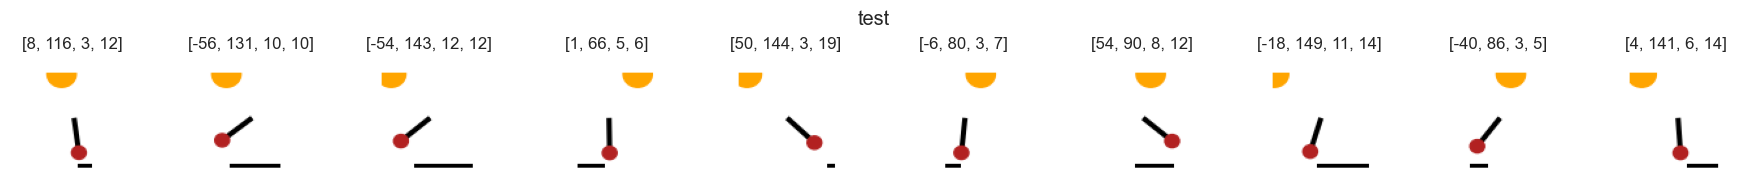

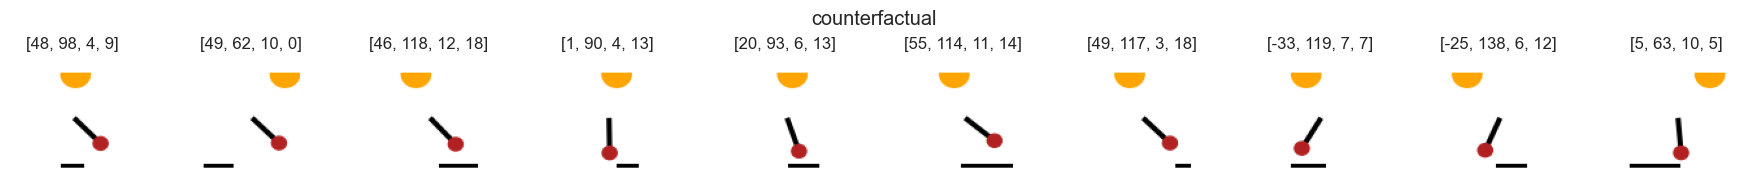

In [7]:
def normalize(img):
    a = np.expand_dims([0.5, 0.5, 0.5], (0,1))
    normalized = img * a + a
    return normalized.clip(0, 1)

for n, dataset in zip(['train', 'test', 'counterfactual'], [train_dataset, test_dataset, cf_dataset]):
    plt.figure(figsize=(18, 2))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        sample = dataset[i]
        plt.imshow(normalize(sample['img'].permute(1, 2, 0)))
        plt.title(str(sample['label'].tolist()))
        plt.axis('off')
    plt.suptitle(n, y=.95)
    plt.tight_layout()

In [8]:
BS = 256
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True) #, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False)
cf_loader = DataLoader(cf_dataset, batch_size=BS, shuffle=False)

### 2. Build CVAE

In [9]:
class Encoder(nn.Module):
    def __init__(self, z_dim=Z_DIM, label_dim=4, p=0.1):
        super(Encoder, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(32, 64, 3),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 96, 3),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(96, 96, 3),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Dropout(p)
        )
        self.fc_output_loc = nn.Linear(3456 + label_dim, z_dim)
        self.fc_output_scale = nn.Linear(3456 + label_dim, z_dim)

    def forward(self, x, labels):
        hidden = self.conv_layers(x)
        hidden = torch.cat([hidden, labels], dim=1)
        z_loc = self.fc_output_loc(hidden)
        z_scale = torch.exp(self.fc_output_scale(hidden))
        return z_loc, z_scale

class Decoder(nn.Module):
    def __init__(self, z_dim=Z_DIM, p=0.1):
        super(Decoder, self).__init__()
        self.first_layer = nn.Linear(in_features=z_dim, out_features=96*6*6)
        self.upsampling_layers = nn.Sequential(
            nn.BatchNorm2d(96),
            nn.LeakyReLU(),
            nn.Dropout(p),
            nn.Conv2d(96, 96, 3, 1, 1),
            nn.Upsample((12, 12)),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(96, 64, 3, 1, 1),
            nn.Upsample((24, 24)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.Upsample((48, 48)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 32, 3, 1, 1),
            nn.Upsample((96, 96)),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(32, 3, 3, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.first_layer(z).view((-1, 96, 6, 6))
        return self.upsampling_layers(x)

In [10]:
class CVAE(nn.Module):
    def __init__(self, z_dim=Z_DIM, label_dim=4, p=0.2, use_cuda=False):
        super().__init__()
        self.encoder_ = Encoder(z_dim, label_dim=label_dim, p=p)
        self.decoder_ = Decoder(z_dim + label_dim, p=p)
        if use_cuda:
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim
        self.label_dim = label_dim

    def model(self, x, labels):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        pyro.module("decoder", self.decoder_)

        with pyro.plate("data", x.shape[0]):
            # pior for Z
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

            # decode img using z
            loc_img = self.decoder_(torch.cat([z, labels], dim=1))
            pyro.sample("obs", dist.Bernoulli(loc_img.squeeze()).to_event(3), obs=x.squeeze())

    def guide(self, x, labels):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        pyro.module("encoder", self.encoder_)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder_(x, labels)
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def encoder(self, x, labels, return_cpu=True):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        z_loc, z_scale = self.encoder_(x, labels)
        if self.use_cuda and return_cpu:
            z_loc = z_loc.cpu()
            z_scale = z_scale.cpu()
        return z_loc, z_scale

    def decoder(self, z, labels, return_cpu=True):
        if self.use_cuda:
            z = z.cuda()
            labels = labels.cuda()
        loc_img = self.decoder_(torch.cat([z, labels], dim=1))
        if self.use_cuda and return_cpu:
            loc_img = loc_img.cpu()
        return loc_img

    @torch.inference_mode()
    def reconstruct_img(self, x, labels, return_cpu=True):
        z_loc, z_scale = self.encoder(x, labels)
        z = dist.Normal(z_loc, z_scale).sample()
        loc_img = self.decoder(z, labels)
        return loc_img

### 3. Load CVAE, graph, SCM weights

In [11]:
USE_CUDA = torch.cuda.is_available()
pyro.clear_param_store()
vae = CVAE(z_dim=Z_DIM, p=0.1, use_cuda=USE_CUDA)
vae.load_state_dict(torch.load('../../train_CVAE/pendulum_zdim=3/vae_06_08_exp2.pth',
                               map_location='cuda' if USE_CUDA else 'cpu'))
vae.train(False);

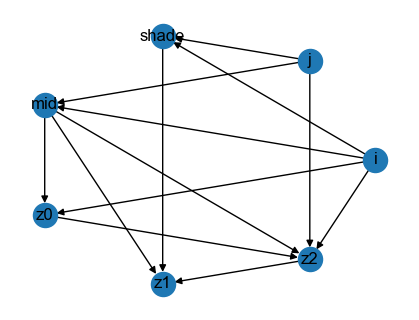

In [12]:
### Using Zs in CAUSICA
vardist_mode = np.array([[0., 0., 1., 1., 1., 0., 1.],
       [0., 0., 1., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.]], dtype=np.float32)

import networkx as nx
labeldict = {i: l for i, l in enumerate(['i', 'j', 'shade', 'mid']+['z'+str(j) for j in range(Z_DIM)])}
graph = nx.from_numpy_array(vardist_mode, create_using=nx.DiGraph)
plt.figure(figsize=(4, 3))
nx.draw_circular(graph, labels=labeldict, with_labels=True, arrows=True)

In [13]:
import pickle
with open('params_zdim3_scm.pkl', "rb") as f:
    scm_params = pickle.load(f)

In [14]:
class SCM_Inference():
    def __init__(self, vardist_mode, scm_params, vae, z_dim=Z_DIM, num_labels=4,
                 label_sizes=[1,1,1,1], BS=8):
        self.z_names = ['Z'+str(i) for i in range(z_dim)]
        self.var_names = np.array(['Y'+str(i+1) for i in range(num_labels)] + self.z_names)
        self.feat_dims = {k: ls for k, ls in zip(self.var_names, label_sizes + list(np.ones(z_dim, dtype=int)))}
        self.name_to_num = {k: i for i, k in enumerate(self.var_names)}
        self.vardist_mode = vardist_mode
        self.scm_params = scm_params
        self.z_dim = z_dim
        self.BS = BS
        self.vae = vae

    @staticmethod
    def get_onehot_bias(Y_parents, Z_parents):
        if len(Y_parents):
            BS = len(Y_parents[0])
        else:
            BS = len(Z_parents[0])
        onehot_bias = []
#         for Y in Y_parents:
#             onehot_bias.append(F.one_hot(Y.to(torch.int64), num_classes=10).float())
        for Z in Y_parents + Z_parents:
            onehot_bias.append(Z[:, None])
        onehot_bias.append(torch.ones(BS, 1))
        return torch.cat(onehot_bias, dim=1)

    def get_sample_inf(self, sample_dict, y_dict, sigma_dict, var_name):
        '''sample_dict - dict with samples, changing
        y_dict, sigma_dict - consts'''

        if var_name in sample_dict:
            return sample_dict
        num = self.name_to_num[var_name]
        parents = self.var_names[self.vardist_mode[:, num].astype(bool)]
        if len(parents) == 0:
            if var_name[0] != 'Y':
                var_mu = self.scm_params['a_'+var_name].repeat(self.BS, 1)
        else:
            if var_name[0] != 'Y':
                Y_parents, Z_parents = [], []
                for parent in parents:
                    sample_dict = self.get_sample_inf(sample_dict, y_dict, sigma_dict, parent)
                    if parent[0] == 'Y':
                        Y_parents.append(sample_dict[parent])
                    elif parent[0] == 'Z':
                        Z_parents.append(sample_dict[parent])
                var_mu = self.get_onehot_bias(Y_parents, Z_parents) @ self.scm_params['a_'+var_name]
        if var_name[0] == 'Y':
            sample_dict[var_name] = torch.tensor(y_dict[var_name]).repeat(self.BS)
        else:
            sample_dict[var_name] = dist.Normal(var_mu, sigma_dict[var_name]).sample().flatten()
        return sample_dict

    def scm_infer(self, ys, sigmas):
        y_dict = {'Y1': ys[0], 'Y2': ys[1], 'Y3': ys[2], 'Y4': ys[3]}
        sigma_dict = {'Z'+str(i): sigmas[i] for i in range(self.z_dim)}
        sample_dict = {}
        for var_name in self.var_names:
            if var_name not in sample_dict:
                sample_dict = self.get_sample_inf(sample_dict, y_dict, sigma_dict, var_name)

        z = torch.stack([sample_dict[z] for z in self.z_names]).T
        labels = torch.tensor([list(y_dict.values())] * self.BS)
        loc_img = vae.decoder(z, labels).detach().cpu()

        return loc_img # (BS, 3, H, W)

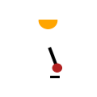

In [15]:
# SAMPLE IMAGE FOR SIGMA
def plot_image(x, s):
    plt.figure(figsize=(s, s))
    plt.imshow(normalize(x.cpu()))
    plt.axis('off')
    
batch = next(iter(test_loader))
idx = np.random.randint(0, len(batch['label']))
x = batch['img'][idx:idx+1]
l = batch['label'][idx:idx+1]
mu, sigma = vae.encoder(x, l)
plot_image(x[0].permute(1,2,0), 1);

### 4. Metric

In [16]:
NUM_PER_COMB = 4
scm_inference = SCM_Inference(vardist_mode, scm_params, vae, BS=NUM_PER_COMB)

In [17]:
import math

def projection(theta, phi, x, y, base=-0.5):
    b = y - x * np.tan(phi)
    shade = (base - b) / np.tan(phi)
    return shade

def get_true_shade(i, j):
    theta = i * math.pi / 200.0
    phi = j * math.pi / 200.0
    ball_x = 10 + 9.5 * np.sin(theta)
    ball_y = 10.5 - 9.5 * np.cos(theta)
    true_shade = np.maximum(3, np.abs(projection(theta, phi, 10.0, 10.5) - projection(theta, phi, ball_x, ball_y)))
    true_mid = (projection(theta, phi, 10.0, 10.5) + projection(theta, phi, ball_x, ball_y)) / 2
    return true_shade, true_mid

In [18]:
def scm_generate(vae, ys, z_dim=Z_DIM, BS=NUM_PER_COMB, sigma_=0.1):
    if ys[2] is None:
        ys[2], ys[3] = get_true_shade(*ys[:2])
    z_loc = torch.zeros(z_dim)
    z_scale = torch.ones(z_dim) * sigma_
    z = dist.Normal(z_loc, z_scale).sample((BS,))
    loc_img = scm_inference.scm_infer(torch.tensor(ys).int(), sigma.detach().flatten())
    return loc_img

def show_pictures(loc_img):
    BS = len(loc_img)
    f, ax = plt.subplots(1, BS, figsize=(12, 1))
    ax = ax.flatten()
    for i in range(BS):
        ax[i].imshow(normalize(loc_img[i].permute(1, 2, 0)))
        ax[i].axis('off')
    plt.show()

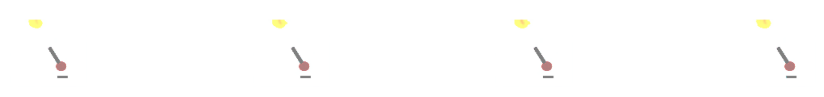

In [123]:
loc_img = scm_generate(vae, [30, 110, None, None])
show_pictures(loc_img)

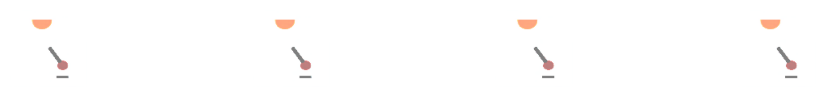

In [122]:
loc_img = scm_generate(vae, [30, 110, 1, 23], BS=8)
show_pictures(loc_img)

In [21]:
gen_imgs = []
gen_labels = []
cf_imgs = []
cf_labels = []
for i in tqdm(range(-60, 60)):
    for j in range(50, 150):
        if j == 100 or j == 0:
            continue

        # TRUE COMBINATION
        true_shade, true_mid = get_true_shade(i, j)
        ys = [i, j, true_shade, true_mid]
        gen_imgs.append(scm_inference.scm_infer(torch.tensor(ys).int(), sigma.detach().flatten()))
        gen_labels.extend([ys] * NUM_PER_COMB)

        # CF COMBINATION
        shade = np.random.randint(3, 14)
        while shade == true_shade:
            shade = np.random.randint(3, 14)
        mid = np.random.randint(-2, 22)
        while mid == true_mid:
            mid = np.random.randint(-2, 22)
        ys = [i, j, shade, mid]
        cf_imgs.append(scm_inference.scm_infer(torch.tensor(ys).int(), sigma.detach().flatten()))
        cf_labels.extend([ys] * NUM_PER_COMB)

100%|█████████████████████████████████████████| 120/120 [04:24<00:00,  2.20s/it]


In [26]:
gen_imgs = torch.stack(gen_imgs).flatten(end_dim=1)
cf_imgs = torch.stack(cf_imgs).flatten(end_dim=1)
gen_labels = torch.tensor(gen_labels)
cf_labels = torch.tensor(cf_labels)
gen_imgs.shape, cf_imgs.shape, gen_labels.shape, cf_labels.shape

(torch.Size([47520, 3, 96, 96]),
 torch.Size([47520, 3, 96, 96]),
 torch.Size([47520, 4]),
 torch.Size([47520, 4]))

In [27]:
class DatasetForInference(Dataset):
    def __init__(self, imgs, labels):
        self.imgs = imgs
        self.labels = labels

    def __getitem__(self, idx):
        ret = {
            'img': self.imgs[idx],
            'label': self.labels[idx],
        }
        return ret

    def __len__(self):
        return self.labels.shape[0]

In [28]:
train_inf_dataset = DatasetForInference(gen_imgs, gen_labels)
cf_inf_dataset = DatasetForInference(cf_imgs, cf_labels)

BATCH_SIZE = 40
train_inf_loader = DataLoader(train_inf_dataset, batch_size=BATCH_SIZE, shuffle=True)
cf_inf_loader = DataLoader(cf_inf_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [65]:
class PendulumRegressor(nn.Module):
    def __init__(self, dropout_p=0.5):
        super(PendulumRegressor, self).__init__()
        self.p = 0.4
        self.shade_net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(192, 64),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.Linear(64, 2),
        )
        self.sun_net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2304, 512),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.Linear(64, 1),
        )
        self.pend_net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1960, 512),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        sun = x[:, 1, :24].unsqueeze(1)
        pend, shade = x[:, 1, 45:80, 20:-20].unsqueeze(1), x[:, 1, 83:85]
        sun_pred = self.sun_net(sun)
        pend_pred = self.pend_net(pend)
        shade_pred = self.shade_net(shade)
        return torch.cat([pend_pred, sun_pred, shade_pred], dim=1)

In [144]:
device = f"cuda" if torch.cuda.is_available() else "cpu"
regressor = PendulumRegressor().to(device)
regressor.load_state_dict(torch.load('../../pendulum_regressor/regressor.pth', map_location='cpu'))

<All keys matched successfully>

In [145]:
def mse(A, B):
    return ((A - B)**2).mean(axis=1)
    
def get_mse_allfour(loader):
    with torch.no_grad():
        mses_Y11 = []
        mses_Y12 = []
        mses_Y21 = []
        mses_Y22 = []
        for batch in tqdm(loader):
            X_batch = batch['img']
            y_batch = batch['label']
            pred = regressor(X_batch) # (BS, 30)
            mses_Y11.extend(mse(y_batch[:, 0], pred.detach()[:, 0:1]))
            mses_Y12.extend(mse(y_batch[:, 1], pred.detach()[:, 1:2]))
            mses_Y21.extend(mse(y_batch[:, 2], pred.detach()[:, 2:3]))
            mses_Y22.extend(mse(y_batch[:, 3], pred.detach()[:, 3:4]))
        return np.stack([mses_Y11, mses_Y12, mses_Y21, mses_Y22])    

In [146]:
mse_train = get_mse_allfour(train_inf_loader)
mse_cf = get_mse_allfour(cf_inf_loader)

print('\nTRAIN:', mse_train.mean(axis=1))
print('CF:   ', mse_cf.mean(axis=1))

100%|██████████████████████████████████████| 1188/1188 [00:05<00:00, 234.99it/s]



TRAIN: [1917.55698612 2757.27940379   14.51370125   30.7957719 ]
CF:    [  99.58081  1186.9052     30.204935   59.46502 ]


New regressor (V2)

In [138]:
class PendulumRegressor(nn.Module):
    def __init__(self, dropout_p=0.5):
        super(PendulumRegressor, self).__init__()
        self.p = 0.4
        self.shade_net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(192, 64),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.Linear(64, 2),
        )
        self.sun_net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2304, 512),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.Linear(64, 1),
        )
        self.pend_net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1960, 512),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        sun = x[:, :, :24].min(axis=1)[0].unsqueeze(1)
        pend = x[:, :, 45:80, 20:-20].min(axis=1)[0].unsqueeze(1)
        shade = x[:, :, 83:85].min(axis=1)[0]
        sun_pred = self.sun_net(sun)
        pend_pred = self.pend_net(pend)
        shade_pred = self.shade_net(shade)
        return torch.cat([pend_pred, sun_pred, shade_pred], dim=1)

In [139]:
regressor = PendulumRegressor().to(device)
regressor.load_state_dict(torch.load('../../pendulum_regressor/regressor_v2.pth', map_location='cpu'))

<All keys matched successfully>

In [140]:
mse_train = get_mse(train_inf_loader)
mse_cf = get_mse(cf_inf_loader)

print('\nTRAIN:', mse_train.mean(axis=1))
print('CF:   ', mse_cf.mean(axis=1))

100%|██████████████████████████████████████| 1188/1188 [00:06<00:00, 184.03it/s]



TRAIN: [1878.18506466 1365.64063366  330.51462884   10.34338721]
CF:    [108.314606 801.9926   391.76767   42.57906 ]
